In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import xgboost
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.shape

(39074, 16)

In [3]:
df.describe()

,id,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,is_rich
count,39074.000000,39074.000000,3.907400e+04,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000
mean,29304.500000,38.694631,1.895940e+05,10.074576,1046.173875,87.393433,40.433895,0.239520
std,11279.836546,13.731323,1.058920e+05,2.572794,7302.852120,403.706583,12.373732,0.426796
min,9768.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,19536.250000,28.000000,1.174770e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,29304.500000,37.000000,1.781505e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,39072.750000,48.000000,2.371285e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,48841.000000,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39074 entries, 0 to 39073
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               39074 non-null  int64 
 1   age              39074 non-null  int64 
 2   workclass        39074 non-null  object
 3   fnlwgt           39074 non-null  int64 
 4   education        39074 non-null  object
 5   educational-num  39074 non-null  int64 
 6   marital-status   39074 non-null  object
 7   occupation       39074 non-null  object
 8   relationship     39074 non-null  object
 9   race             39074 non-null  object
 10  gender           39074 non-null  object
 11  capital-gain     39074 non-null  int64 
 12  capital-loss     39074 non-null  int64 
 13  hours-per-week   39074 non-null  int64 
 14  native-country   39074 non-null  object
 15  is_rich          39074 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 4.8+ MB


## Пропуски отсутствуют

In [5]:
df.isna().sum().sort_values(ascending=False)

id                 0
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
is_rich            0
dtype: int64

In [6]:
X = df.drop(["is_rich", "id"], axis=1)
y = df['is_rich']

## Выборка несбалансирована

In [7]:
y.value_counts()

0    29715
1     9359
Name: is_rich, dtype: int64

## Разделение выборки с учетом несбалансированности

In [8]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
train_y.value_counts()

0    26743
1     8423
Name: is_rich, dtype: int64

## Выбросы

In [9]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries
boundaries = calculate_outliers(train_x.age)
boundaries

(-2.0, 78.0)

In [10]:
is_outlier = (train_x.age < boundaries[0]) | (train_x.age > boundaries[1]) 
is_outlier.sum()

170

In [11]:
train_x.loc[is_outlier, 'age'] = int(boundaries[1])
is_outlier = (train_x.age < boundaries[0]) | (train_x.age > boundaries[1]) 
is_outlier.sum()

0

In [12]:
boundaries = calculate_outliers(test_x.age)
boundaries

(-0.5, 75.5)

In [13]:
is_outlier = (test_x.age < boundaries[0]) | (test_x.age > boundaries[1]) 
is_outlier.sum()

25

In [14]:
test_x.loc[is_outlier, 'age'] = int(boundaries[1])
is_outlier = (test_x.age < boundaries[0]) | (test_x.age > boundaries[1]) 
is_outlier.sum()

0

In [15]:
boundaries = calculate_outliers(train_x.fnlwgt)
boundaries

(-62367.375, 417217.625)

In [16]:
is_outlier = (train_x.fnlwgt < boundaries[0]) | (train_x.fnlwgt > boundaries[1])
is_outlier.sum()

1053

In [17]:
boundaries = calculate_outliers(train_x["hours-per-week"])
boundaries

(32.5, 52.5)

In [18]:
is_outlier = (train_x["hours-per-week"] < boundaries[0]) | (train_x["hours-per-week"] > boundaries[1])
is_outlier.sum()

9667

In [19]:
boundaries = calculate_outliers(test_x["hours-per-week"])
boundaries

(32.5, 52.5)

In [20]:
is_outlier = (test_x["hours-per-week"] < boundaries[0]) | (test_x["hours-per-week"] > boundaries[1])
is_outlier.sum()

1075

## Стандартизация и работа с категориальными переменными

In [21]:
num_cols = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week"
]

cat_cols = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native-country"
]

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_mm = scaler.fit_transform(train_x[num_cols])
X_train_mm = pd.DataFrame(data = x_train_mm,  
                  columns =['age_std','fnlwgt_std','educational-num_std',
                           "capital-gain_std", "capital-loss_std", "hours-per-week_std"])
x_test_mm = scaler.transform(test_x[num_cols])
X_test_mm = pd.DataFrame(data = x_test_mm,  
                  columns =['age_std','fnlwgt_std','educational-num_std',
                           "capital-gain_std", "capital-loss_std", "hours-per-week_std"])
train_x = pd.concat([X_train_mm, train_x.reset_index(drop=True)], axis=1)
test_x = pd.concat([X_test_mm, test_x.reset_index(drop=True)], axis=1)
columns_for_drop = ["age","fnlwgt","educational-num","capital-gain","capital-loss",
                    "hours-per-week"]
train_x = train_x.drop(columns=columns_for_drop) 
test_x = test_x.drop(columns=columns_for_drop) 

In [23]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

ft = ohe.fit_transform(train_x[cat_cols])
df_ft = pd.DataFrame(ft, columns=ohe.get_feature_names_out())
train_x = pd.concat([df_ft, train_x], axis=1)
ft1 = ohe.transform(test_x[cat_cols])
df_ft1 = pd.DataFrame(ft1, columns=ohe.get_feature_names_out())
test_x = pd.concat([df_ft1, test_x], axis=1)
columns_for_drop = ["workclass", "education", "marital-status", "occupation", "relationship",
    "race","gender","native-country"]
train_x = train_x.drop(columns=columns_for_drop) 
test_x = test_x.drop(columns=columns_for_drop) 

## EDA

In [37]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,id,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,is_rich
id,1.00,-0.01,0.01,0.00,-0.00,0.01,-0.00,0.00
age,-0.01,1.00,-0.08,0.02,0.07,0.06,0.07,0.23
fnlwgt,0.01,-0.08,1.00,-0.04,-0.00,-0.01,-0.01,-0.01
educational-num,0.00,0.02,-0.04,1.00,0.12,0.08,0.14,0.33
capital-gain,-0.00,0.07,-0.00,0.12,1.00,-0.03,0.08,0.22
capital-loss,0.01,0.06,-0.01,0.08,-0.03,1.00,0.05,0.15
hours-per-week,-0.00,0.07,-0.01,0.14,0.08,0.05,1.00,0.23
is_rich,0.00,0.23,-0.01,0.33,0.22,0.15,0.23,1.00


## Видим отсутствие сильной корреляции между целевой переменной и другими числовыми признаками

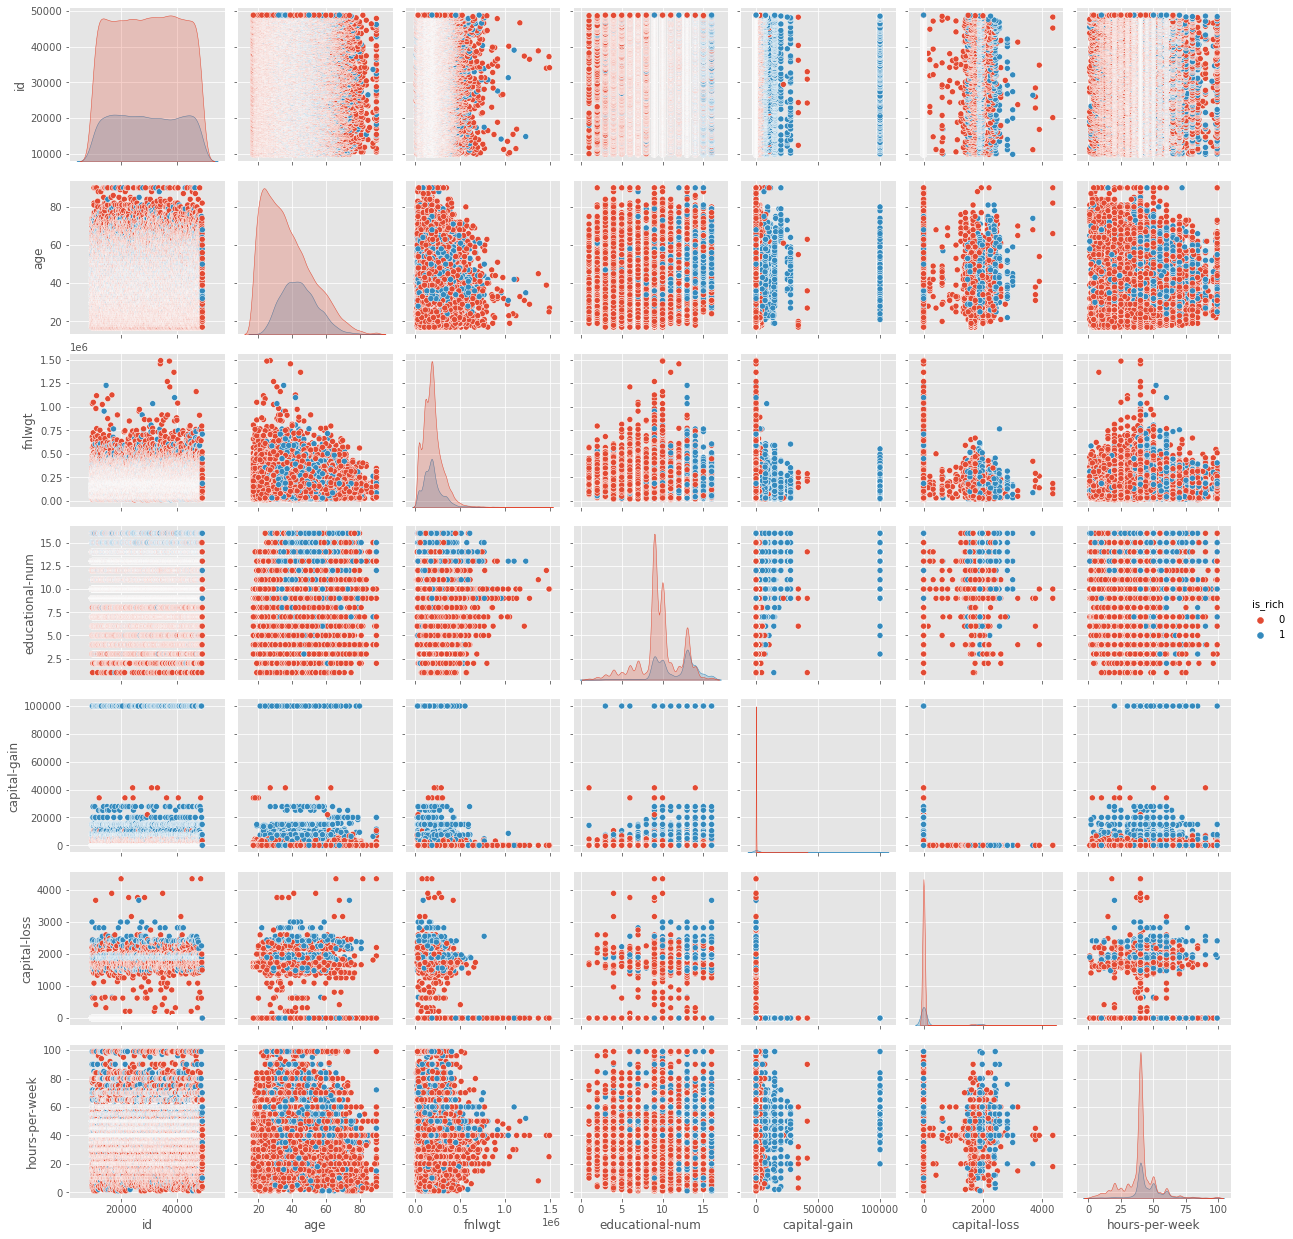

In [38]:
import seaborn as sns
sns.pairplot(df, hue='is_rich')

plt.show()

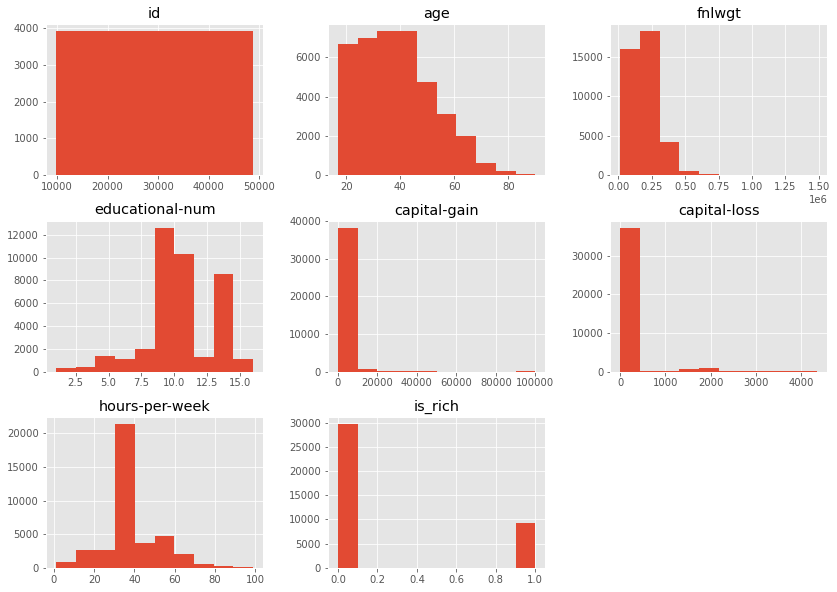

In [39]:
df.hist(column=df.columns, figsize=(14, 10))
None

## Если прирост капитала от 5 до 20 и больше либо равно 100, то с большой долей вероятности это богатый человек


## Если educational num < 8, то вероятность того, что человек бедный велика

## Такое впечатление что количество времени, которое работает человек, не влияет на целевую переменную

In [40]:
df.head(2)

,id,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,is_rich
0,9768,41,Private,130408,HS-grad,9,Divorced,Sales,Unmarried,Black,Female,0,0,38,United-States,0
1,9769,17,Private,57723,11th,7,Never-married,Sales,Own-child,White,Male,0,0,30,United-States,0


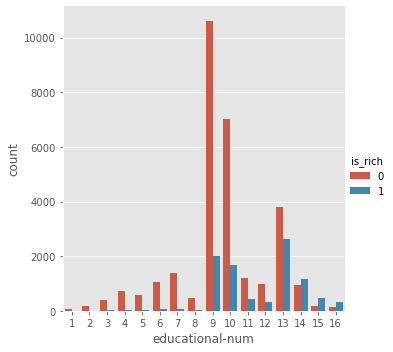

In [41]:
sns.catplot(x='educational-num',
            hue='is_rich',
            kind='count',
            data=df);

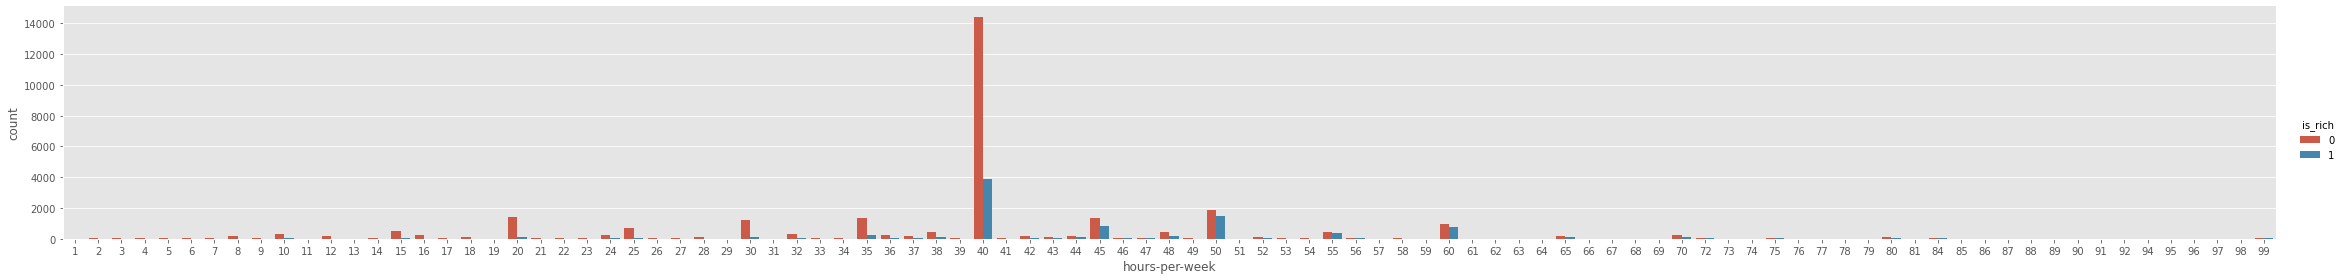

In [42]:
sns.catplot(x='hours-per-week',
            hue='is_rich',
            kind='count',
            height= 4, aspect= 8,
            data=df);

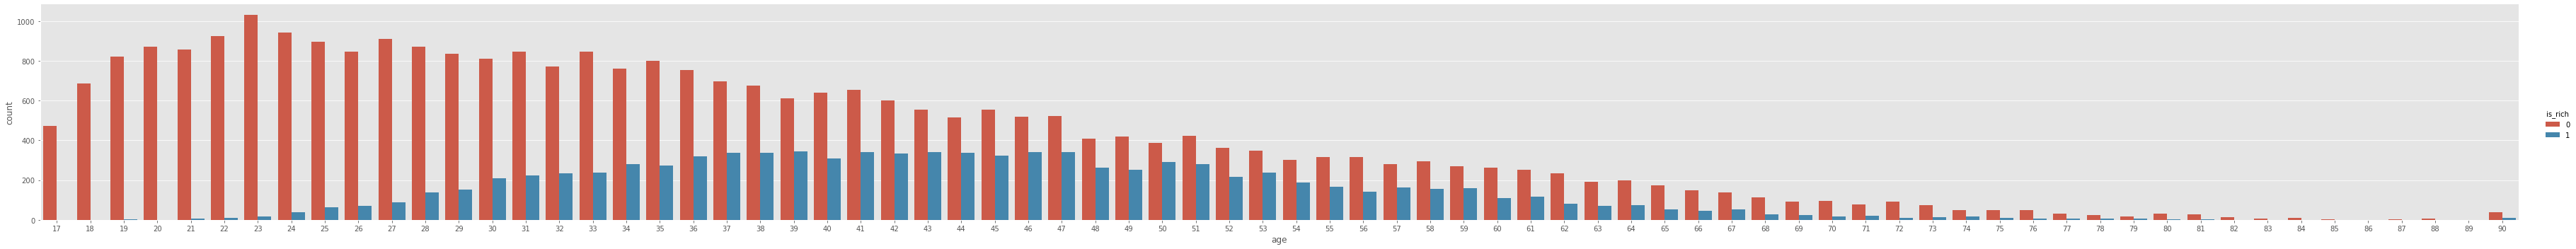

In [43]:
sns.catplot(x='age',
            hue='is_rich',
            kind='count',
            height= 5, aspect= 10,
            data=df);

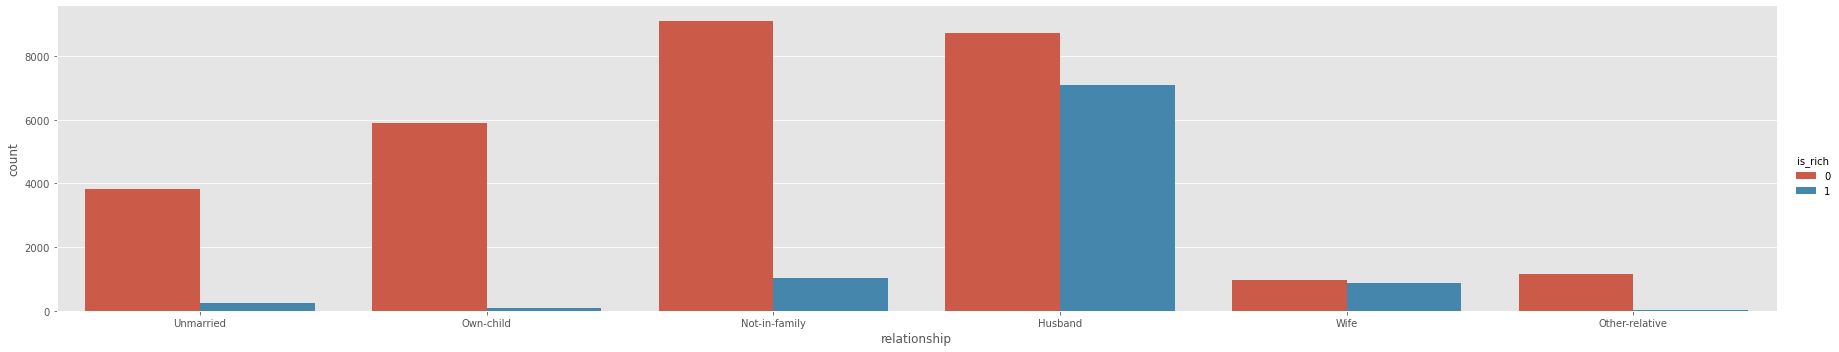

In [44]:
sns.catplot(x='relationship',
            hue='is_rich',
            kind='count',
            height= 5, aspect= 5,
            data=df);

## Если ты женат/замужем  ты можешь быть бедным можешь быть богатым
## но если ты не женат/не замужем вероятность того, что ты беден велика

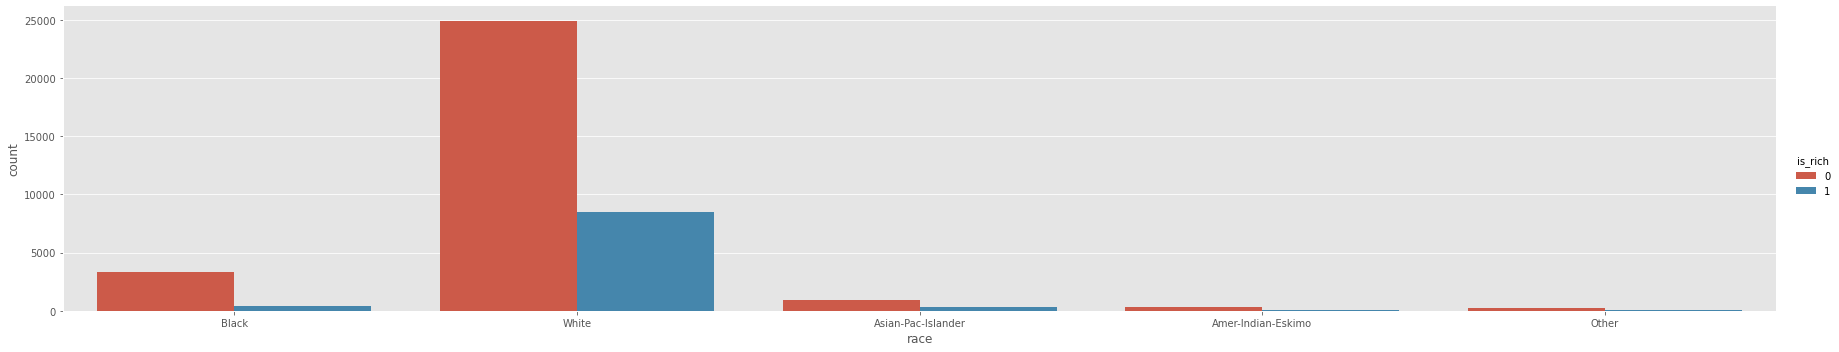

In [45]:
sns.catplot(x='race',
            hue='is_rich',
            kind='count',
            height= 5, aspect= 5,
            data=df);

## среди белых богатых больше

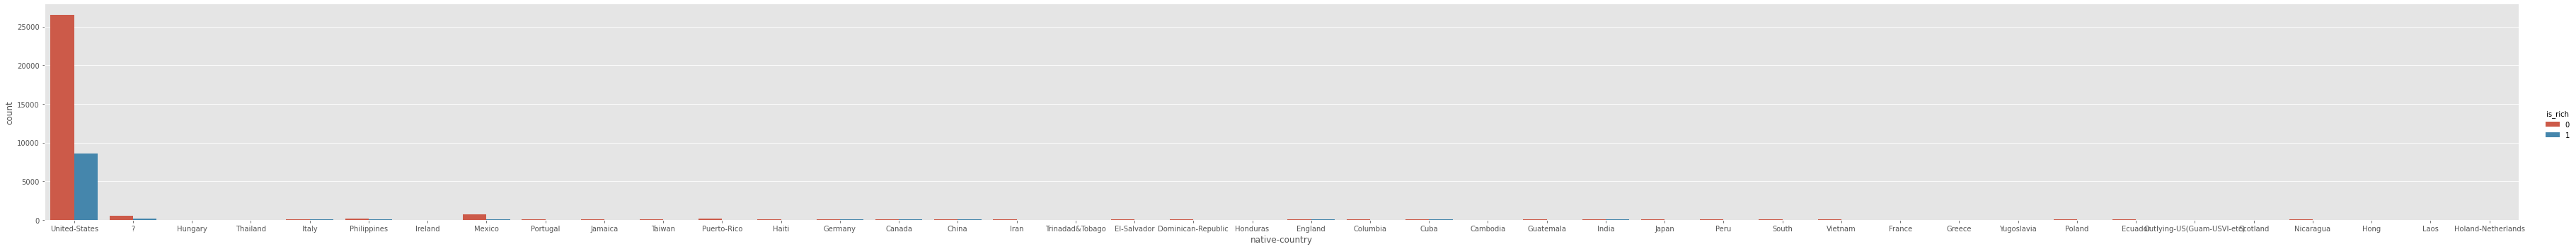

In [46]:
sns.catplot(x='native-country',
            hue='is_rich',
            kind='count',
            height= 5, aspect= 10,
            data=df);

## среди тех кто родился в Америке богатых больше

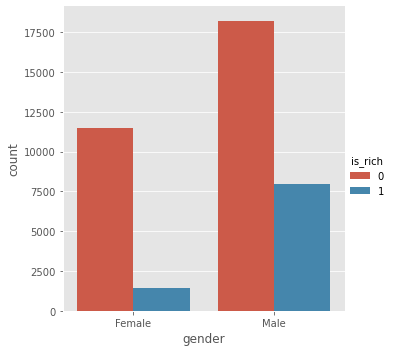

In [47]:
sns.catplot(x='gender',
            hue='is_rich',
            kind='count',
            data=df);

## Среди мужчин богатых больше

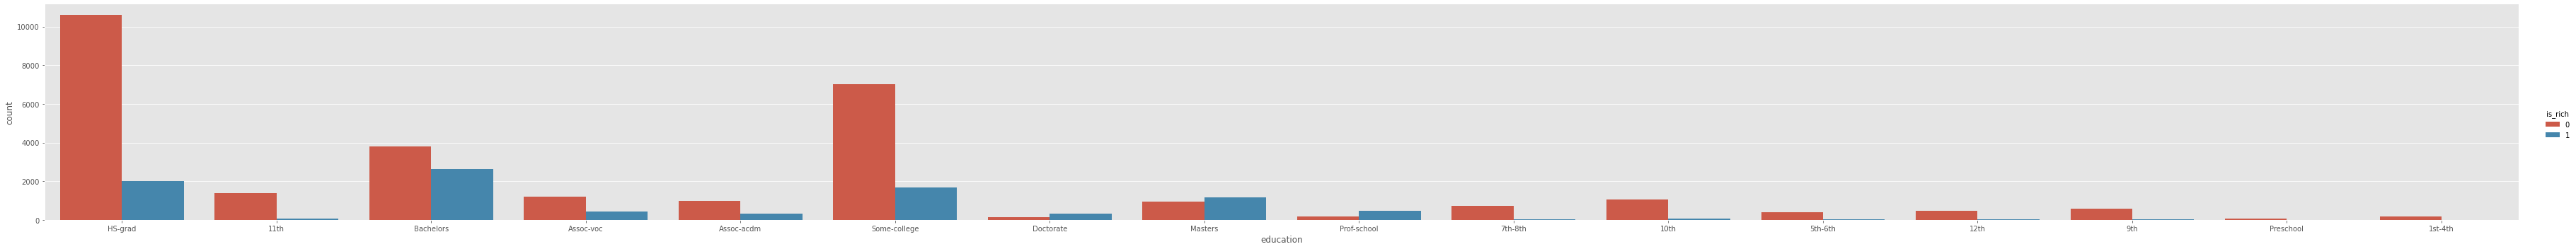

In [48]:
sns.catplot(x='education',
            hue='is_rich',
            kind='count',
            height= 5, aspect= 10,
            data=df);

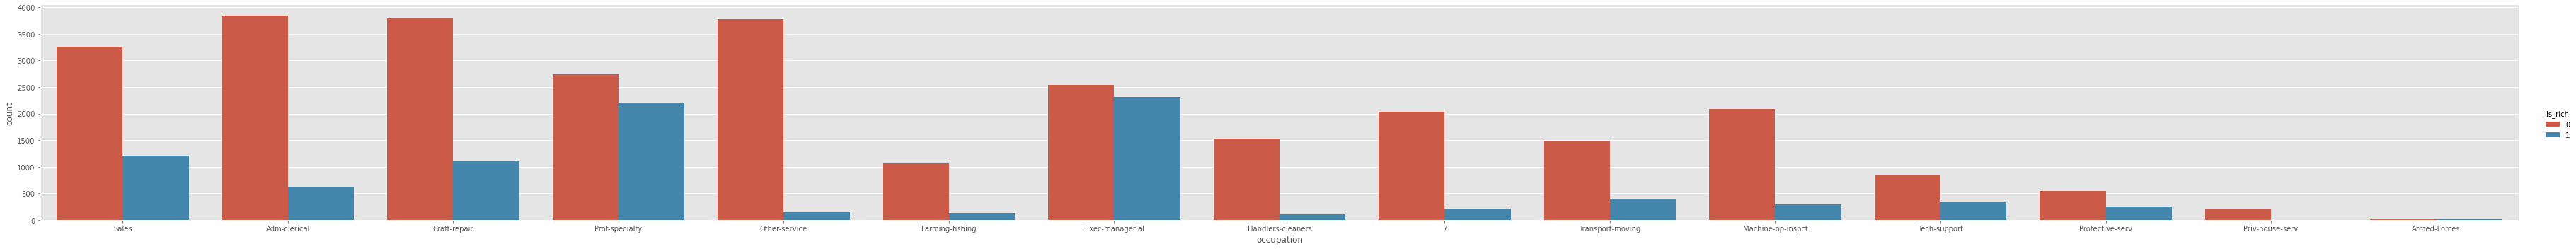

In [49]:
sns.catplot(x='occupation',
            hue='is_rich',
            kind='count',
            height= 5, aspect= 10,
            data=df);

## Машинное обучение

In [24]:
f1 = make_scorer(f1_score, average='micro')

## Логистическая регрессия

In [51]:
logreg = LogisticRegression(random_state = 42)
logreg.fit(train_x, train_y)
prediction = logreg.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8469805527123848

In [52]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv2 = LogisticRegressionCV(Cs=[0.001,0.01,0.1,1,10,100,1000,10000,100000],random_state=0, solver='liblinear',multi_class='ovr',penalty='l2',max_iter=100,cv=3,scoring=f1,class_weight='balanced')
lr_cv2.fit(train_x, train_y)
prediction = lr_cv2.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8037359263050154

In [53]:
lr_cv1 = LogisticRegressionCV(Cs=[0.01,0.1,1,5,10,50,100],random_state=0, solver='liblinear',multi_class='ovr',penalty='l1',max_iter=100,cv=3,scoring=f1,class_weight='balanced')
lr_cv1.fit(train_x, train_y)
prediction = lr_cv1.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8039918116683725

In [55]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)
qwe = ada.fit(train_x, train_y)
prediction = qwe.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8628454452405321

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, 
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, 
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
gbdt.fit(train_x, train_y)
prediction = gbdt.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.862589559877175

## Тюнинг логистической регрессии

In [56]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': np.logspace(-4, 4, 50),
'penalty': ['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state = 42), param_grid, cv = 5, verbose = 0, n_jobs = -1, scoring = f1)
best_model = clf.fit(train_x, train_y) 
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

{'C': 0.5689866029018293, 'penalty': 'l2'}
0.8516749321944264
LogisticRegression(C=0.5689866029018293, random_state=42)


In [57]:
param_grid = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty': ['l2', 'none']}
clf = GridSearchCV(LogisticRegression(random_state = 42), param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring=f1)
best_model = clf.fit(train_x, train_y)
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

{'penalty': 'l2', 'solver': 'newton-cg'}
0.8506511971790934
LogisticRegression(random_state=42, solver='newton-cg')


## KNN

In [46]:
from sklearn.model_selection import GridSearchCV
params = {
    "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
    "metric": ['manhattan', 'euclidean'],
    "weights": ['uniform', 'distance']
}
clf = KNeighborsClassifier()
clf_grid = GridSearchCV(clf, params, cv=5, scoring=f1, n_jobs=-1)
clf_grid.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, average=micro))

In [47]:
print(clf_grid.best_params_)
print(clf_grid.best_score_)
print(clf_grid.best_estimator_)

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}
0.8314405945848409
KNeighborsClassifier(metric='manhattan', n_neighbors=19)


## MLP

In [58]:
mlp = MLPClassifier(random_state=42).fit(train_x, train_y)
prediction = mlp.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.832906857727738

## Случайный лес

In [59]:
rfmodel = RandomForestClassifier(random_state = 42).fit(train_x, train_y)
prediction = rfmodel.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8477482088024565

## Тюнинг случайного леса

Text(0, 0.5, 'f2 on test')

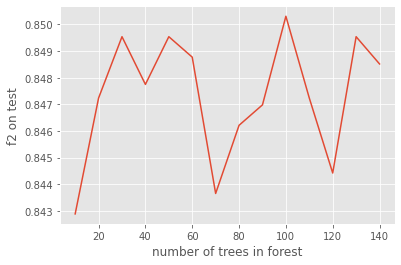

In [28]:
N = []
f2 = []

for n in np.arange(10, 150, 10):
    rf = RandomForestClassifier(n_estimators = n)

    rf.fit(train_x, train_y)

    pred_rf = rf.predict(test_x)
    N.append(n)
    f2.append(f1_score(test_y,  pred_rf, average='micro'))

plt.plot(N, f2, '-')
plt.xlabel('number of trees in forest')
plt.ylabel('f2 on test')


In [29]:
f_imp_list1 = list(zip(N, f2))
f_imp_list1.sort(key = lambda x: x[1], reverse=True)
f_imp_list1[:5]

[(100, 0.8503070624360286),
 (30, 0.849539406345957),
 (50, 0.849539406345957),
 (130, 0.849539406345957),
 (60, 0.8487717502558854)]

In [ ]:
parameters = {'max_depth' : np.arange(2, 100, 4),
          'max_features' : ['sqrt', 'log2', None],
          'min_samples_split' : [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
          'min_samples_leaf' : [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
          }
xlf = RandomForestClassifier(n_estimators=100)
cv = RandomizedSearchCV(estimator = xlf, param_distributions=parameters, scoring = f1, n_iter = 80, cv=3, n_jobs = -1)
cv.fit(train_x, train_y)    
print(cv.best_params_)
print(cv.best_score_)

In [25]:
best_model = RandomForestClassifier(n_estimators=100, max_depth = 26, min_samples_split = 12, min_samples_leaf =2, max_features = "sqrt")
best_model.fit(train_x, train_y)
prediction = best_model.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.862589559877175

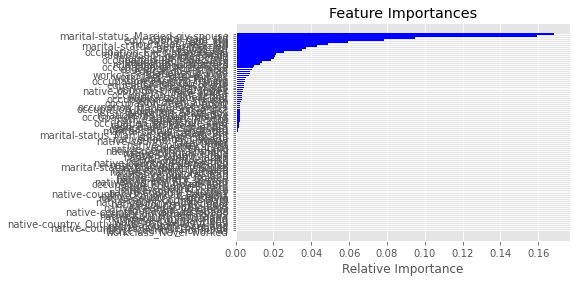

In [26]:
features = train_x.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [27]:
f_imp_list2 = list(zip(features, best_model.feature_importances_))
f_imp_list2.sort(key = lambda x: x[1], reverse=True)
f_imp_list2[:10]

[('marital-status_Married-civ-spouse', 0.16851062841926584),
 ('capital-gain_std', 0.1591812996024835),
 ('educational-num_std', 0.09474966945834998),
 ('age_std', 0.07834510067533988),
 ('hours-per-week_std', 0.059246351908854536),
 ('marital-status_Never-married', 0.04868087598155458),
 ('capital-loss_std', 0.0431771306205921),
 ('fnlwgt_std', 0.03739968838132728),
 ('occupation_Exec-managerial', 0.03505907819343884),
 ('relationship_Not-in-family', 0.025440085197528287)]

## Catboost

In [36]:
parameters = {
              'depth': [1, 4, 7, 10, 13, 16, 19],
              'learning_rate': [0.03, 0.1, 0.15, 0.3, 0.9],
              'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
              'iterations': [100, 200, 300, 400, 500]}
label_ratio = (y==1).sum()/(y==0).sum()
cb = cb.CatBoostClassifier(scale_pos_weight = label_ratio, logging_level='Silent')          
cv = RandomizedSearchCV(estimator = cb, scoring = f1, param_distributions=parameters, n_iter = 90, cv=3, n_jobs = -1)
cv.fit(train_x, train_y)    
print(cv.best_params_)
print(cv.best_score_)

0:	learn: 0.4807712	total: 527ms	remaining: 3m 30s
1:	learn: 0.3852653	total: 914ms	remaining: 3m 1s
2:	learn: 0.3067269	total: 1.29s	remaining: 2m 51s
3:	learn: 0.2595446	total: 1.67s	remaining: 2m 45s
4:	learn: 0.2329402	total: 2.06s	remaining: 2m 42s
5:	learn: 0.2154774	total: 2.47s	remaining: 2m 42s
6:	learn: 0.2028368	total: 2.88s	remaining: 2m 41s
7:	learn: 0.1942831	total: 3.23s	remaining: 2m 38s
8:	learn: 0.1877790	total: 3.59s	remaining: 2m 36s
9:	learn: 0.1857923	total: 3.6s	remaining: 2m 20s
10:	learn: 0.1810357	total: 3.97s	remaining: 2m 20s
11:	learn: 0.1778140	total: 4.33s	remaining: 2m 20s
12:	learn: 0.1751652	total: 4.71s	remaining: 2m 20s
13:	learn: 0.1732975	total: 5.1s	remaining: 2m 20s
14:	learn: 0.1710415	total: 5.52s	remaining: 2m 21s
15:	learn: 0.1695734	total: 5.88s	remaining: 2m 21s
16:	learn: 0.1679503	total: 6.24s	remaining: 2m 20s
17:	learn: 0.1662974	total: 6.6s	remaining: 2m 20s
18:	learn: 0.1650984	total: 6.95s	remaining: 2m 19s
19:	learn: 0.1639781	total

## XGBOOST

In [28]:
clf_1 = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=(y.value_counts()[0]/y.value_counts()[1])).fit(train_x, train_y)
prediction = clf_1.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8295803480040943

## Тюнинг модели

In [ ]:
parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [1, 5, 15, 200],
              'subsample': [0.6, 0.8, 0.95],
              'colsample_bytree': [0.5, 0.7, 0.9], 
}
xlf = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=(y.value_counts()[0]/y.value_counts()[1]))        
cv = RandomizedSearchCV(estimator = xlf, param_distributions=parameters, n_iter = 80, cv=3, n_jobs = -1, scoring = f1)
cv.fit(train_x, train_y)    
print(cv.best_params_)
print(cv.best_score_)

In [ ]:
f_imp_list = list(zip(train_x.columns, cv.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)
f_imp_list[:5]

## Pytorch

In [32]:
import torch
import random
import numpy as np
random.seed(0) 
np.random.seed(0) 
torch.manual_seed(0) 

In [33]:
train_X = train_x.to_numpy ()
test_X = test_x.to_numpy ()
train_Y = train_y.to_numpy ()
test_Y = test_y.to_numpy ()
X_train = torch.FloatTensor(train_X) 
X_test = torch.FloatTensor(test_X) 
y_train = torch.LongTensor(train_Y)
y_test = torch.LongTensor(test_Y)

In [34]:
class RichNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(RichNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(100, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    
model = RichNet(5)

In [35]:
from torch import nn
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1.0e-2)


In [37]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [38]:
def learn_binary_classification_model(model, n_epochs, print_every_epoch=None):
    if print_every_epoch is None:
        print_every_epoch = n_epochs / 100
    torch.manual_seed(42)

    for epoch in range(n_epochs):
        ### Обучение
        model.train()

        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits)) 

        loss = loss_fn(y_logits,
                       y_train.float()) 
        acc = accuracy_fn(y_true=y_train, 
                          y_pred=y_pred) 

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
      
            test_logits = model(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
     
            test_loss = loss_fn(test_logits,
                                y_test.float())
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)

      
        if epoch % print_every_epoch == 0:
            print(f"Epoch: {epoch:3} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    
    
learn_binary_classification_model(model, 5000)

Epoch:   0 | Loss: 0.59998, Accuracy: 76.05% | Test loss: 0.59404, Test acc: 76.05%
Epoch:  50 | Loss: 0.52336, Accuracy: 76.05% | Test loss: 0.52234, Test acc: 76.05%
Epoch: 100 | Loss: 0.44153, Accuracy: 76.05% | Test loss: 0.44035, Test acc: 76.05%
Epoch: 150 | Loss: 0.37471, Accuracy: 83.48% | Test loss: 0.37520, Test acc: 83.89%
Epoch: 200 | Loss: 0.35319, Accuracy: 83.70% | Test loss: 0.35380, Test acc: 83.81%
Epoch: 250 | Loss: 0.34109, Accuracy: 84.17% | Test loss: 0.34406, Test acc: 84.09%
Epoch: 300 | Loss: 0.33280, Accuracy: 84.49% | Test loss: 0.33727, Test acc: 84.63%
Epoch: 350 | Loss: 0.32663, Accuracy: 84.82% | Test loss: 0.33314, Test acc: 84.77%
Epoch: 400 | Loss: 0.32087, Accuracy: 85.11% | Test loss: 0.32955, Test acc: 84.84%
Epoch: 450 | Loss: 0.31544, Accuracy: 85.42% | Test loss: 0.32621, Test acc: 84.99%
Epoch: 500 | Loss: 0.31031, Accuracy: 85.70% | Test loss: 0.32326, Test acc: 85.03%
Epoch: 550 | Loss: 0.30591, Accuracy: 85.84% | Test loss: 0.32076, Test acc: